In [ ]:
import sys
!conda install --yes --prefix {sys.prefix} biopython

In [3]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from Bio import Phylo
from Bio.Phylo import NexusIO

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import plot_tree

In [4]:
# reading file
data_df = pd.read_csv("C:\\Users\\Lucy\\Downloads\\species_data.csv")
subclade_df = pd.read_csv("C:\\Users\\Lucy\\Downloads\\subclades.csv")
tree = Phylo.read("C:\\Users\\Lucy\\Downloads\\terrestrial_vertebrate_tree.nexus.trees.txt", "nexus")

In [22]:
j = subclade_df[subclade_df["Binomial"] == data_df.iloc[0]["Species"]].index
j[0]

48804

In [20]:
if len(subclade_df[subclade_df["Binomial"] == "Meow"].index) == 0:
    print("meow")

meow


In [25]:
subcl = []
for i in range(len(data_df)):
    inds = subclade_df[subclade_df["Binomial"] == data_df.iloc[i]["Species"]].index
    if len(inds) < 1:
        subcl.append(None)
    elif len(inds) > 1:
        print("Error at index ", i, "! More than one entry found for ", data_df.iloc[i]["Species"])
    else:
        subcl.append(subclade_df.iloc[inds[0]]["Subclade"])

263

In [37]:
new_data_df = data_df.assign(Subclade = subcl)
new_data_df.to_csv("species_data_and_subclades.csv", index = False)

In [36]:
new_data_df[new_data_df["Class"] == "Amphibia"]["Subclade"].value_counts()

Bufonidae          6
Hylidae            4
Dendrobatidae      4
Alytidae           2
Ambystomatidae     2
Leptodactylidae    2
Ranidae            2
Ascaphidae         1
Ceratophryidae     1
Microhylidae       1
Dermophiidae       1
Mantellidae        1
Megophryidae       1
Salamandridae      1
Pipidae            1
Typhlonectidae     1
Name: Subclade, dtype: int64

In [4]:
#list of terminal descentants sorted
leaf_names = [leaf.name for leaf in tree.get_terminals()]
leaf_names = pd.Series(leaf_names)
leaf_names = leaf_names.sort_values()

In [5]:
#data already sorted and making list 
data_names = data_df.iloc[:, 0].values

not_in_tree = []
not_in_data = []

for leaf in leaf_names:
    if leaf not in data_names:
        not_in_data.append(leaf)
        
for name in data_names:
    if name not in leaf_names.values:
        not_in_tree.append(name)

In [6]:
#found the leaf nodes that are in tree but not in data_df#removing the leaf nodes from tree than are not in data_df
#length of nodes have changed in the nexus tree but will not change analyis - soley used for grouping families
for clade in not_in_data:
    tree.prune(clade)

#new sorted list with all terminal leaf names that are consistent with data_df    
new_leaf_names = [leaf.name for leaf in tree.get_terminals()]
new_leaf_names = pd.Series(new_leaf_names)
new_leaf_names = new_leaf_names.sort_values()

In [14]:
#new tree file
with open("new_tree", "w") as f:
    NexusIO.write([tree], f)

In [7]:
#Looking at tree we should do all four classes first 
#(avians, amphibians, mammals, reptiles seperately and then try to go smaller) 

# Amphibians
clade_amp1 = next(tree.find_clades("Typhlonectes_natans"))
clade_amp2 = next(tree.find_clades("Anaxyrus_baxteri"))
amp_com_anc_node = tree.common_ancestor(clade_amp1, clade_amp2)
amp_list = []
for tc in amp_com_anc_node.find_clades(terminal=True):
    amp_list.append(tc.name)
    
#mammals
clade_mam1 = next(tree.find_clades("Didelphis_marsupialis"))
clade_mam2 = next(tree.find_clades("Mustela_putorius"))
mam_com_anc_node = tree.common_ancestor(clade_mam1, clade_mam2)
mam_list = []
for tc in mam_com_anc_node.find_clades(terminal=True):
    mam_list.append(tc.name)

#Reptiles
clade_rep1 = next(tree.find_clades("Eublepharis_macularius"))
clade_rep2 = next(tree.find_clades("Crotalus_horridus"))
rep_com_anc_node = tree.common_ancestor(clade_rep1, clade_rep2)
rep_list = []
for tc in rep_com_anc_node.find_clades(terminal=True):
    rep_list.append(tc.name)

#Birds
clade_ava1 = next(tree.find_clades("Eudromia_elegans"))
clade_ava2 = next(tree.find_clades("Uraeginthus_bengalus"))
ava_com_anc_node = tree.common_ancestor(clade_ava1, clade_ava2)
ava_list = []
for tc in ava_com_anc_node.find_clades(terminal=True):
    ava_list.append(tc.name)

In [8]:
def indicator(clade_list):
    bin_list = []
    indicator_ind = np.where(data_df['Species'].isin(clade_list))[0]
    for i in range(0, len(data_df)):
        if i in indicator_ind:
            bin_list.append(1)
        else:
            bin_list.append(0)
    return bin_list

rep_bin = indicator(rep_list)
ava_bin = indicator(ava_list)
mam_bin = indicator(mam_list)
amp_bin = indicator(amp_list)

data_df['isMam'] = mam_bin
data_df['isRep'] = rep_bin
data_df['isAmp'] = amp_bin
data_df['isAva'] = ava_bin

In [9]:
amps_df = data_df[data_df["Species"].isin(amp_list)]

In [32]:
bins = []
for i in range(len(amps_df)):
    if (amps_df.iloc[i]["neo"] <= 2):
        bins.append("low-med")
    elif (amps_df.iloc[i]["neo"] <= 5):
        bins.append("high")
    elif (amps_df.iloc[i]["neo"] <= 12):
        bins.append("very-high")
    elif (amps_df.iloc[i]["neo"] > 12):
        bins.append("outlying-high")

amps_bin_df = amps_df.assign(bin_neo=bins)

In [38]:
feature = ["log_bm", "log_pl"]
X = amps_bin_df[feature]
y = amps_bin_df.bin_neo

In [39]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

In [40]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [41]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8


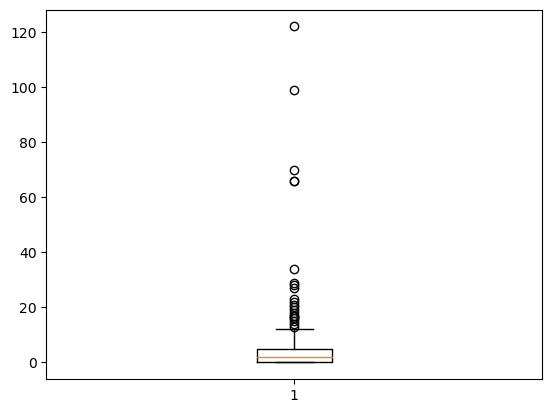

In [18]:
bp = plt.boxplot(data_df["neo"])

neo_min = min(data_df["neo"]) # 0
neo_boxmin = [line.get_ydata()[1] for line in bp['whiskers'][::2]] # 0
neo_q1 = [line.get_ydata()[1] for line in bp['boxes']] # 0
neo_med = [line.get_ydata()[0] for line in bp['medians']] # 2
neo_q3 = [line.get_ydata()[2] for line in bp['boxes']] # 5
neo_boxmax = [line.get_ydata()[1] for line in bp['whiskers'][1::2]] # 12
neo_max = max(data_df["neo"]) # 122

In [92]:
newbins = []
for i in range(len(data_df)):
    if (data_df.iloc[i]["neo"] <= neo_q1):
        newbins.append("low")
    elif (data_df.iloc[i]["neo"] <= neo_med):
        newbins.append("med")
    elif (data_df.iloc[i]["neo"] <= neo_q3):
        newbins.append("high")
    elif (data_df.iloc[i]["neo"] <= neo_boxmax):
        newbins.append("very-high")
    elif (data_df.iloc[i]["neo"] > neo_boxmax):
        newbins.append("outlying-high")

new_data_df = data_df.assign(bin_neo = newbins)

In [137]:
nclass, ntherm, nonmal, malratio = [], [], [], []
for i in range(len(new_data_df)):
    if (new_data_df.iloc[i].therm == "ectothermic"):
        ntherm.append(0)
    else:
        ntherm.append(1)
    
    if (new_data_df.iloc[i].Class == "Amphibia"):
        nclass.append(0)
    elif (new_data_df.iloc[i].Class == "Aves"):
        nclass.append(1)
    elif (new_data_df.iloc[i].Class == "Mammalia"):
        nclass.append(2)
    else:
        nclass.append(3)
    
    nonmal.append(new_data_df.iloc[i].neo - new_data_df.iloc[i].mal)
    if new_data_df.iloc[i].neo != 0:
        malratio.append(new_data_df.iloc[i].mal / new_data_df.iloc[i].neo)
    else:
        malratio.append("NA")
    
new_data_df = new_data_df.assign(nClass = nclass)
new_data_df = new_data_df.assign(nTherm = ntherm)
new_data_df = new_data_df.assign(nonmal = nonmal)
new_data_df = new_data_df.assign(malRatio = malratio)

new_data_df

,Species,Class,therm,common_name,rec,neo,mal,log_bm,log_pl,log_rec,isMam,isRep,isAmp,isAva,bin_neo,nClass,nTherm,nonmal,malRatio
0,Acinonyx_jubatus,Mammalia,endothermic,Cheetah,79,12,3,10.751499,5.843350,4.369448,1,0,0,0,very-high,2,1,9,0.25
1,Acrantophis_dumerili,Reptilia,ectothermic,Dumerils boa,22,4,2,7.443078,5.141461,3.091042,0,1,0,0,high,3,0,2,0.5
2,Acrobates_pygmaeus,Mammalia,endothermic,Feathertail glider,43,0,0,2.484907,5.504776,3.761200,1,0,0,0,low,2,1,0,NA
3,Acryllium_vulturinum,Aves,endothermic,Vulturine guineafowl,39,5,4,7.192934,4.537370,3.663562,0,0,0,1,high,1,1,1,0.8
4,Addax_nasomaculatus,Mammalia,endothermic,Addax,30,5,4,11.156255,6.277205,3.401197,1,0,0,0,high,2,1,1,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,Varecia_variegata,Mammalia,endothermic,Red/black ruffed lemur,48,16,11,8.116716,5.234766,3.871201,1,0,0,0,outlying-high,2,1,5,0.6875
259,Vini_australis,Aves,endothermic,Blue crowned lory,27,0,0,4.007333,5.234005,3.295837,0,0,0,1,low,1,1,0,NA
260,Vulpes_zerda,Mammalia,endothermic,Fennec fox,22,7,6,7.003065,5.533878,3.091042,1,0,0,0,very-high,2,1,1,0.857143
261,Zalophus_californianus,Mammalia,endothermic,California sealion,57,11,8,11.289782,5.974439,4.043051,1,0,0,0,very-high,2,1,3,0.727273


In [94]:
n = 0
for i in range(len(new_data_df)):
    if (new_data_df.iloc[i].neo - new_data_df.iloc[i].mal < 0):
        print("neg val at ", i)
    else:
        n = n+1
n

263